In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import normalize_data
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import clean_data

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 12)

def __jday_convert(x):
    '''
    Algorithm from python-sgp4:

    from sgp4.functions import jday
    jday(x.year, x.month, x.day, x.hour, x.minute, x.second + x.microsecond * 1e-6)
    '''
    jd = (367.0 * x.year
         - 7 * (x.year + ((x.month + 9) // 12.0)) * 0.25 // 1.0
           + 275 * x.month / 9.0 // 1.0
           + x.day
         + 1721013.5)
    fr = (x.second + (x.microsecond * 1e-6) + x.minute * 60.0 + x.hour * 3600.0) / 86400.0;
    return jd, fr

# Load and Prepare Dataset

In [2]:
# Load Data
X = pd.read_pickle(f'data/x_secret_test1.pkl')
y = pd.read_pickle(f'data/y_secret_test1.pkl')

# Limit y columns
y_cols = y.columns
x_cols = ['BSTAR', 'INCLINATION', 'RA_OF_ASC_NODE', 'ECCENTRICITY',
       'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'MEAN_MOTION', 'SUNSPOTS_1D',
       'SUNSPOTS_3D', 'SUNSPOTS_7D', 'AIR_MONTH_AVG_TEMP',
       'WATER_MONTH_AVG_TEMP', 'year', 'month_sin', 'month_cos', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos',
       'ms_sin', 'ms_cos', 'year_y', 'month_sin_y', 'month_cos_y',
       'hour_sin_y', 'hour_cos_y', 'minute_sin_y', 'minute_cos_y',
       'second_sin_y', 'second_cos_y', 'ms_sin_y', 'ms_cos_y',
       'epoch_day_diff', 'epoch_sec_diff', 'epoch_ms_diff']

In [3]:
X_dn = clean_data.normalize_all_columns(X.copy(),reverse=True)
y_dn = clean_data.normalize_all_columns(y.copy(),reverse=True)

# Load Models and Make Predictions

In [4]:
from dataset_nm import Dataset, to_device

#def predict_model(model, X, y, device='cpu'):
def predict_one_feature(model, X, y, device='cpu'):
    pyt_device = torch.device(device)
    
    to_device(model, pyt_device)

    batch_size = 2000
    predictDataset = Dataset(X, y)
    predictLoader = torch.utils.data.DataLoader(dataset=predictDataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=5,
                                              pin_memory=True
                                             )
    num_elements = len(predictLoader.dataset)
    num_outputs = len(y.columns)
    num_batches = len(predictLoader)
    predictions = torch.zeros(num_elements, num_outputs)
    for i, (inputs, _) in tqdm(enumerate(predictLoader), total=num_batches):
        inputs = to_device(inputs, pyt_device)
        start = i*batch_size
        end = start + batch_size
        if i == num_batches - 1:
            end = num_elements
        pred = model(inputs)
        predictions[start:end] = pred.detach().cpu()
    nn_results = predictions.numpy()

    return nn_results

def load_model(name,device,path='models'):
    print(f"{path}/{name}.pth")
    cp = torch.load(f"{path}/{name}.pth",map_location=torch.device('cpu'))
    return cp['net']


# def predict(model_name, X, y, device="cpu"):
#     pred_data = {}
#     y_dummy=pd.DataFrame(np.zeros(len(X)))

#     pred_data = predict_model(load_model(model_name, device), X, y, device=device)

#     y_pred = pd.DataFrame(pred_data, columns=y.columns)
#     return y_pred

def predict(X, y_cols, device="cpu"):
    pred_data = {}
    y_dummy=pd.DataFrame(np.zeros(len(X)))
    
    models = {'ARG_OF_PERICENTER':'n5_ARG_OF_PERICENTER',
              'ECCENTRICITY':'n5_ECCENTRICITY',
              'INCLINATION':'n5_INCLINATION',
              'MEAN_ANOMALY':'n5_MEAN_ANOMALY',
              'MEAN_MOTION':'n5_MEAN_MOTION',
              'RA_OF_ASC_NODE':'n5_RA_OF_ASC_NODE',
             }

    for col in y_cols:
        pred_data[col] = predict_one_feature(load_model(models[col], device), X, y_dummy, device=device).reshape(-1)

    y_pred = pd.DataFrame(pred_data)
    return y_pred

try:
    y_pred = pd.read_pickle('data/y_secret_test_n5_pred.pkl')
except:
    y_pred = predict(X[x_cols], y, 'cuda')
    y_pred.to_pickle('data/y_secret_test_n5_pred.pkl')

In [5]:
y_pred_dn = clean_data.normalize_all_columns(y_pred.copy(),reverse=True)

In [6]:
from_180_deg = ['INCLINATION']
from_360_deg = ['RA_OF_ASC_NODE', 'MEAN_ANOMALY', 'ARG_OF_PERICENTER']
y_pred_dn[from_180_deg] = y_pred_dn[from_180_deg]%180
y_pred_dn[from_360_deg] = y_pred_dn[from_360_deg]%360

# Compare Ground Truth to Predicted

In [9]:
# Show norads with least and most TLEs
ordered_norads = X.groupby('NORAD_CAT_ID')['INCLINATION'].count().sort_values().reset_index().to_numpy()
print(ordered_norads[[-5,-4,-3,-2,-1]])

for pair in ordered_norads:
    if pair[1]>100:
        print(pair)
        break

[[12212 15847]
 [ 7087 15939]
 [17128 15968]
 [12559 16071]
 [12175 16270]]
[32515   101]


In [10]:
X.head()

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,SUNSPOTS_1D,SUNSPOTS_3D,SUNSPOTS_7D,AIR_MONTH_AVG_TEMP,WATER_MONTH_AVG_TEMP,year,month_sin,month_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,ms_sin,ms_cos,year_y,month_sin_y,month_cos_y,hour_sin_y,hour_cos_y,minute_sin_y,minute_cos_y,second_sin_y,second_cos_y,ms_sin_y,ms_cos_y,EPOCH,EPOCH_y,NORAD_CAT_ID,epoch_day_diff,epoch_sec_diff,epoch_ms_diff
0,0.0001,0.553438333333,0.085251944444,0.0247400,0.186124166667,0.815996944444,0.239106264000,0.040,0.022000000000,0.012857142857,0.573,0.458,0.580645161290,0.866025403784,-0.500000000000,-0.965925826289,0.258819045103,-0.587785252292,0.809016994375,-0.978147600734,-0.207911690818,0.668562310705,-0.743656127995,0.096774193548,0.000000000000,1.000000000000,0.258819045103,-0.965925826289,-0.207911690818,-0.978147600734,-0.866025403784,-0.500000000000,-0.999946390683,-0.010354504350,2008-05-16 19:54:43.383455,1993-01-17 11:32:40.748352,21338,0.490321450469,0.348634259259,0.635103
1,0.0000,0.552689444444,0.550222777778,0.0244596,0.865216388889,0.133639722222,0.238279594286,0.170,0.164000000000,0.207714285714,0.408,0.429,0.096774193548,0.000000000000,1.000000000000,0.258819045103,-0.965925826289,-0.207911690818,-0.978147600734,-0.866025403784,-0.500000000000,-0.999946390683,-0.010354504350,0.225806451613,0.000000000000,1.000000000000,-0.965925826289,0.258819045103,-0.500000000000,-0.866025403784,0.587785252292,0.809016994375,0.872551263253,0.488522561399,1993-01-17 11:32:40.748352,1997-01-05 19:35:06.168768,21338,-0.127003591136,0.664976851852,0.579584
2,0.0001,0.553558333333,0.308730833333,0.0246876,0.112939166667,0.888645555556,0.238408816000,0.026,0.018000000000,0.007714285714,0.364,0.373,0.225806451613,0.000000000000,1.000000000000,-0.965925826289,0.258819045103,-0.500000000000,-0.866025403784,0.587785252292,0.809016994375,0.872551263253,0.488522561399,0.387096774194,0.866025403784,0.500000000000,-0.500000000000,0.866025403784,0.743144825477,0.669130606359,0.500000000000,0.866025403784,-0.247320336921,-0.968933770154,1997-01-05 19:35:06.168768,2002-03-09 22:08:05.539775,21338,-0.165542611895,0.893750000000,0.628993
3,0.0001,0.552695555556,0.209585277778,0.0247556,0.397970000000,0.603533611111,0.238825449143,0.222,0.245333333333,0.294285714286,0.940,0.816,0.387096774194,0.866025403784,0.500000000000,-0.500000000000,0.866025403784,0.743144825477,0.669130606359,0.500000000000,0.866025403784,-0.247320336921,-0.968933770154,0.258064516129,-0.500000000000,0.866025403784,0.965925826289,0.258819045103,-0.866025403784,-0.500000000000,0.866025403784,-0.500000000000,0.963951397684,0.266078377370,2002-03-09 22:08:05.539775,1998-12-09 05:40:20.207136,21338,0.103880178681,0.685937500000,0.332639
4,0.0001,0.553406111111,0.142680555556,0.0244288,0.395079166667,0.606430277778,0.238476949714,0.318,0.313333333333,0.277428571429,0.654,0.568,0.258064516129,-0.500000000000,0.866025403784,0.965925826289,0.258819045103,-0.866025403784,-0.500000000000,0.866025403784,-0.500000000000,0.963951397684,0.266078377370,0.870967741935,-0.500000000000,-0.866025403784,-0.866025403784,0.500000000000,-0.866025403784,-0.500000000000,-0.994521895368,0.104528463268,-0.985788505684,0.167991136856,1998-12-09 05:40:20.207136,2017-08-05 20:40:46.776864,21338,-0.596916878339,0.374687500000,0.430272


In [11]:
def plot_norad_test_outputs(norad,ref,y,y_pred,y_cols,subtext='',kind='line',**kwargs):
    if kind == 'scatter':
        fig = plot_norad_test_outputs_scatter(norad,ref,y,y_pred,y_cols,subtext,**kwargs)
        return fig
        
    mask = ref.NORAD_CAT_ID == norad
    n = len(y_cols)

    fig, axs = plt.subplots(n,2,figsize=(17,n*2.5))

    y_test_norad = y[mask].copy()
    y_test_norad['EPOCH'] = ref[mask]['EPOCH_y']
    y_test_norad = y_test_norad.sort_values(by='EPOCH')
    y_test_norad.set_index('EPOCH')[y_cols].plot(subplots=True, ax=axs[:,0], xlabel='',kind=kind, **kwargs)

    y_pred_norad = y_pred[mask].copy()
    y_pred_norad['EPOCH'] = ref[mask]['EPOCH_y']
    y_pred_norad = y_pred_norad.sort_values(by='EPOCH')
    y_pred_norad.set_index('EPOCH')[y_cols].plot(subplots=True, ax=axs[:,1], xlabel='',kind=kind, **kwargs)

    axs[0,0].set_title(f'Ground truth for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    axs[0,1].set_title(f'Predicted for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    return fig

def plot_norad_test_outputs_scatter(norad,ref,y,y_pred,y_cols,subtext='',**kwargs):
    mask = ref.NORAD_CAT_ID == norad
    n = len(y_cols)

    fig, axs = plt.subplots(n,2,figsize=(17,n*2.5))

    y_test_norad = y[mask].copy()
    y_test_norad['EPOCH'] = ref[mask]['EPOCH_y']
    y_test_norad = y_test_norad.sort_values(by='EPOCH')
    for i,col in enumerate(y_cols):
        y_test_norad.plot.scatter(x='EPOCH',y=col,ax=axs[i,0],xlabel='',label=col,**kwargs)

    y_pred_norad = y_pred[mask].copy()
    y_pred_norad['EPOCH'] = ref[mask]['EPOCH_y']
    y_pred_norad = y_pred_norad.sort_values(by='EPOCH')
    for i,col in enumerate(y_cols):
        y_pred_norad.plot.scatter(x='EPOCH',y=col,ax=axs[i,1],xlabel='',label=col,**kwargs)

    axs[0,0].set_title(f'Ground truth for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    axs[0,1].set_title(f'Predicted for {norad} - {len(y_test_norad)} TLEs\n{subtext}')
    return fig

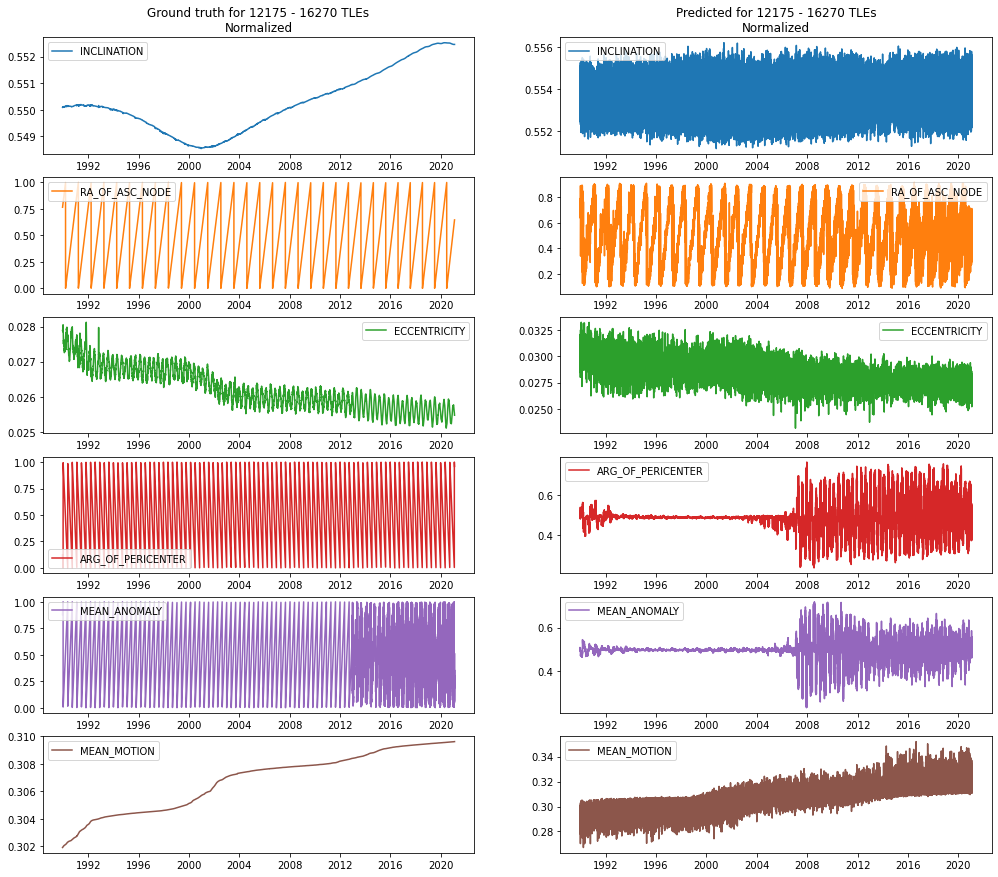

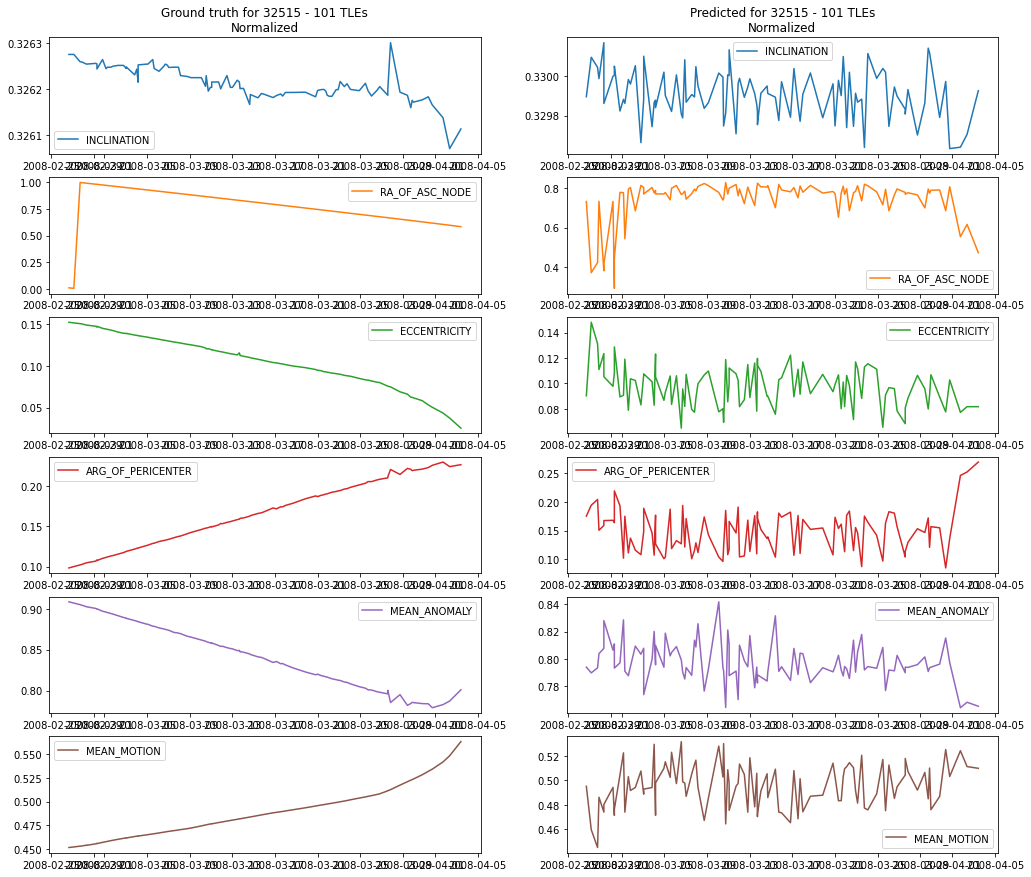

In [12]:
fig = plot_norad_test_outputs(12175,X,y,y_pred,y_cols,'Normalized')
plt.show()

fig = plot_norad_test_outputs(32515,X,y,y_pred,y_cols,'Normalized')
plt.show()

### Zoomed into 1 year

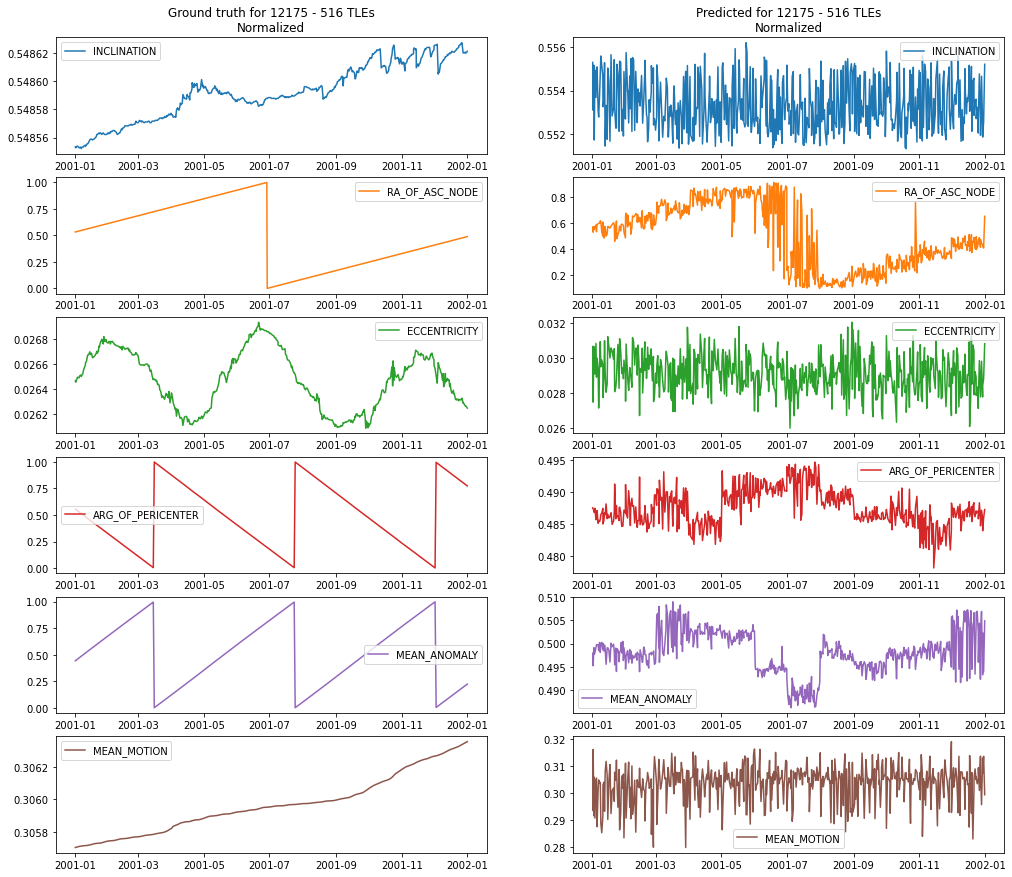

In [13]:
period_y2001_mask = X.EPOCH_y.between(pd.Timestamp(2001,1,1),pd.Timestamp(2002,1,1))
X_y2001 = X[period_y2001_mask].copy()
y_y2001 = y[period_y2001_mask].copy()
y_pred_y2001 = y_pred[period_y2001_mask].copy()
fig = plot_norad_test_outputs(12175,X_y2001,y_y2001,y_pred_y2001,y_cols,'Normalized')
plt.show()

### Zoomed into 30 days

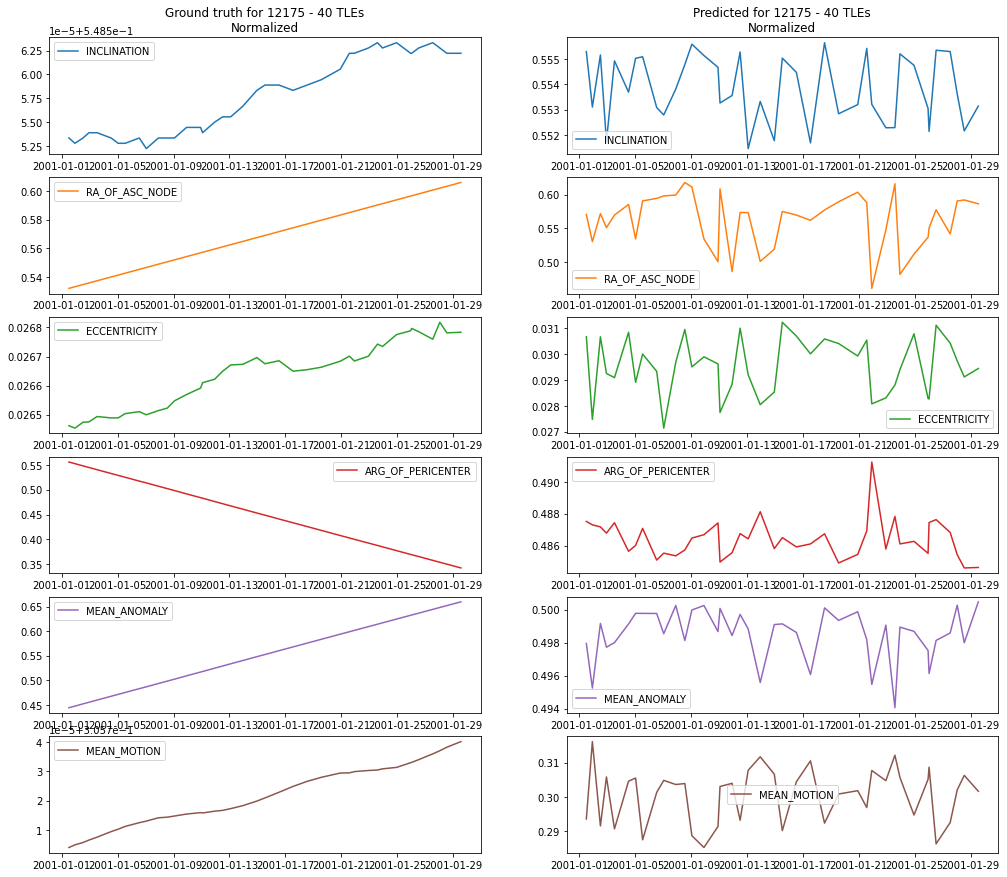

In [14]:
period_30d_mask = X.EPOCH_y.between(pd.Timestamp(2001,1,1),pd.Timestamp(2001,1,30))
#ref_30d = ref[period_30d_mask]
X_30d = X[period_30d_mask].copy()
y_30d = y[period_30d_mask].copy()
y_pred_30d = y_pred[period_30d_mask].copy()
fig = plot_norad_test_outputs(12175,X_30d,y_30d,y_pred_30d,y_cols,'Normalized',kind='line')
plt.show()

### Compare Predictions to their X inputs

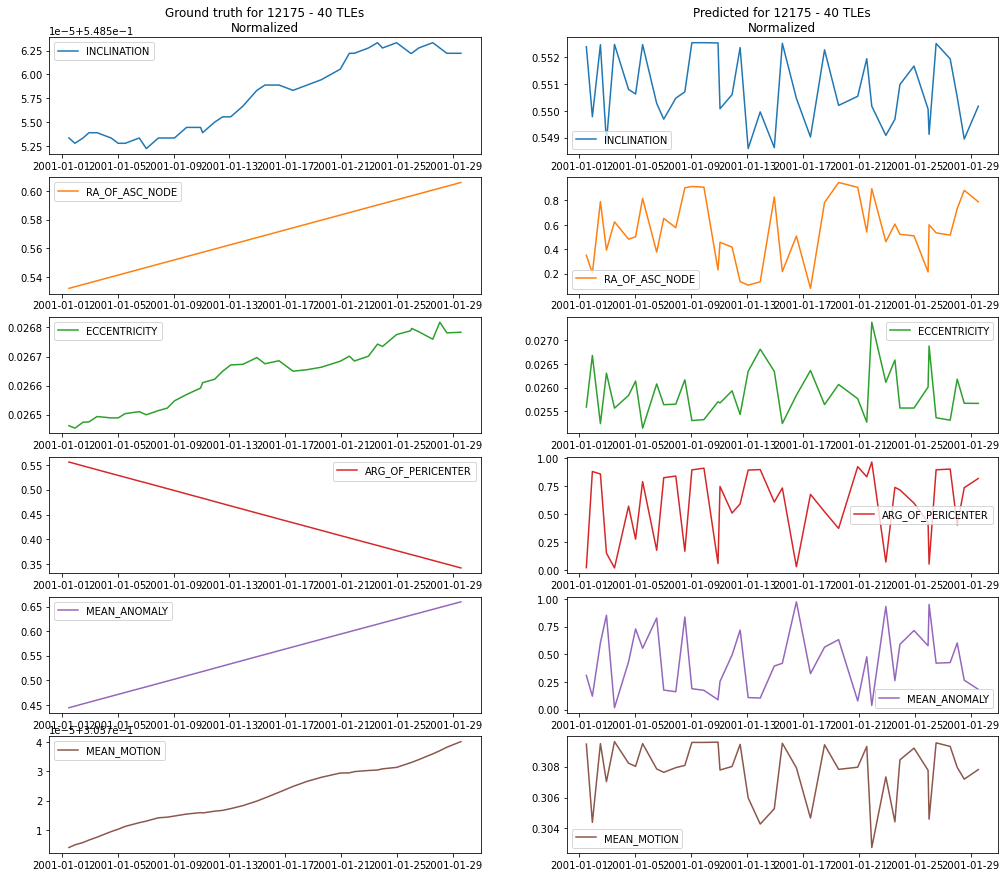

In [15]:
y_pred_X30d = y_pred_30d.copy()
y_pred_X30d[y_cols] = X_30d[y_cols].copy()
fig = plot_norad_test_outputs(12175,X_30d,y_30d,y_pred_X30d,y_cols,'Normalized',kind='line')
plt.show()

### Compare the errors between Prediction and X

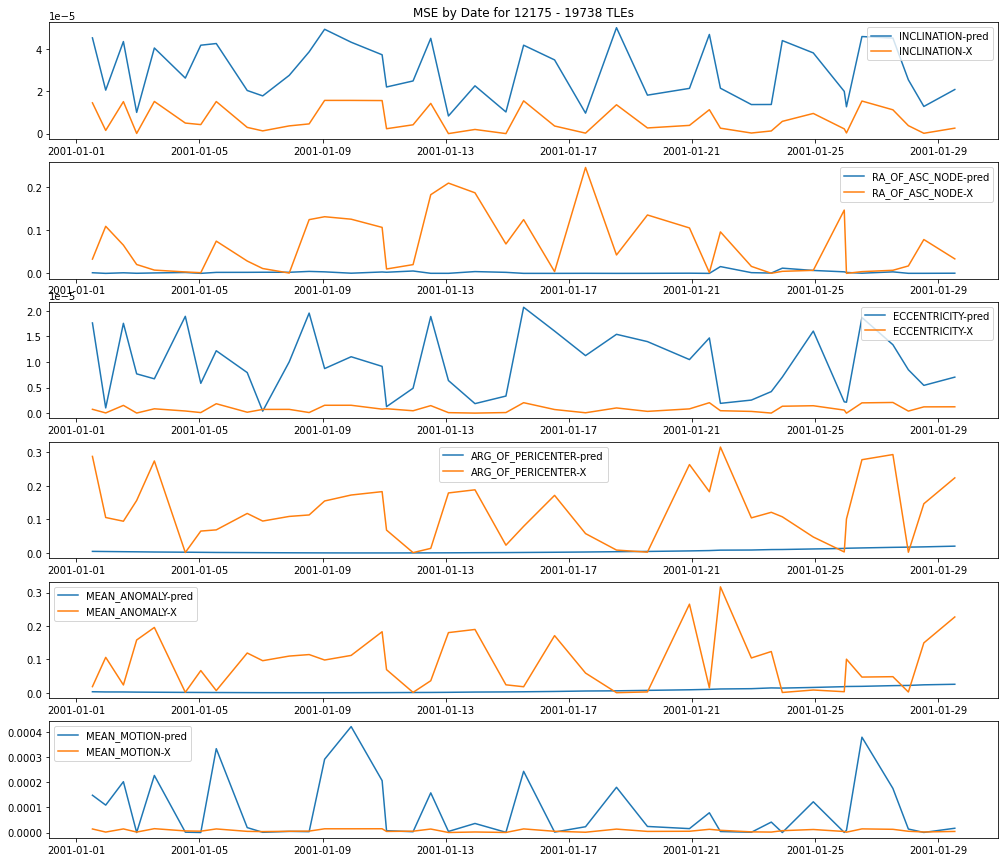

In [16]:
def get_mse(norad,ref,y,y_pred,y_cols):
    mask = ref.NORAD_CAT_ID == norad
    n = len(y_cols)
    y_se = ((y-y_pred)**2)[mask].copy()
    y_se['EPOCH'] = ref[mask]['EPOCH_y']
    y_se = y_se.set_index('EPOCH')
    y_mse = (y_se.groupby(level=0).sum() / y_se.groupby(level=0).count())
    return y_mse
    
def plot_mse(norad,ref,y,y_pred,y_pred_X,y_cols):
    n = len(y_cols)
    fig, axs = plt.subplots(n,1,figsize=(17,n*2.5))

    y_mse = get_mse(norad,ref,y,y_pred,y_cols).reset_index()
    y_mseX = get_mse(norad,ref,y,y_pred_X,y_cols).reset_index()
    
    for i,col in enumerate(y_cols):
        axs[i].plot(y_mse['EPOCH'],y_mse[col],label=f'{col}-pred')
        axs[i].plot(y_mseX['EPOCH'],y_mseX[col],label=f'{col}-X')
        axs[i].legend()
        
    axs[0].set_title(f'MSE by Date for {norad} - {len(y_pred)} TLEs')
    return fig

fig = plot_mse(12175,X_30d,y_30d,y_pred_30d,y_pred_X30d,y_cols)
plt.show()

### Comparison if data is denomarlized

In [17]:
# # These are in sample test:
# fig = plot_norad_test_outputs(12701,ref,y_dn,y_pred_dn,list(y_cols_dn),'Denormalized')
# plt.show()

# fig = plot_norad_test_outputs(38539,ref,y_dn,y_pred_dn,list(y_cols_dn),'Denormalized')
# plt.show()

# Predict For Gaps

In [18]:
def find_gaps(ref, norad, days):
    # Find gaps of 100 days or more
    diff = ref[ref.NORAD_CAT_ID == norad].EPOCH_y.diff(-1)
    diff = diff[diff < -pd.Timedelta(f'{days}d')]
    diff = list(zip(diff.index,diff.index+1))
    dt_pairs = [ref.loc[list(idxs)] for idxs in diff]
    return dt_pairs

def predict_gaps(ref, X, dt_pairs):
    y_gaps = []

    for j, dt_pair in enumerate(dt_pairs):
        # Create a list of epochs to predict
        buffer = pd.Timedelta('1d')  # buffer before and after known TLE
        dt_range = pd.date_range(dt_pair.EPOCH.iloc[0] + buffer, dt_pair.EPOCH.iloc[1] - buffer, freq='1d')

        # Create the ref dataframe for the gap
        ref_gap = dt_pair.iloc[[0]].append([dt_pair.iloc[0]]*(len(dt_range)-1), ignore_index=True)
        ref_gap['EPOCH_y'] = dt_range

        # Create the X dataframe for the gap
        X_gap = X.iloc[[dt_pair.index[0]]].append([X.iloc[dt_pair.index[0]]]*(len(dt_range)-1), ignore_index=True)

        # Preform prediction on X
        y_gap = predict(X_gap, y_cols)

        # Add the epoch
        y_gap['EPOCH'] = ref_gap['EPOCH_y']
        
        # Add the gap to the list
        y_gaps.append(y_gap)
        
    return y_gaps

def plot_gaps(norad, y_gaps, y, y_cols):
    # Setup the Figure
    mask = ref.NORAD_CAT_ID == norad
    n = len(y_cols)
    y_known = y[mask].copy()
    y_known['EPOCH'] = ref[mask]['EPOCH_y']
    y_known_s = y_known.sort_values(by='EPOCH')
    fig, axs = plt.subplots(n,1,figsize=(10,n*2))
    fig.tight_layout(pad=2.0)

    # Add known data to Figure
    for i, col in enumerate(y_cols):
        axs[i].plot(y_known_s.EPOCH, y_known_s[col], label='Known')

    for j, y_gap in enumerate(y_gaps):
        for i, col in enumerate(y_cols):
            label_pred = 'Predicted' if j==0 else None
            label_gap = 'Gap' if j==0 else None

            axs[i].plot(y_gap.EPOCH, y_gap[col], color='orange', label=label_pred)
            axs[i].set_title(col)
            bottom=min(min(c[col]) for c in [y_known_s,y_gap])
            height=max(max(c[col]) for c in [y_known_s,y_gap])-bottom
            width = max(y_gap.EPOCH)-min(y_gap.EPOCH)
            axs[i].add_patch(Rectangle((min(y_gap.EPOCH),bottom), width, height, color='yellow',alpha=0.2, label=label_gap))
            axs[i].legend()
    return fig
    
    
# Find the gaps in the TLE data for a NORAD

# norad = 38539
# gap_size_in_days=100

# dt_pairs = find_gaps(ref, norad=norad, days=gap_size_in_days)
# y_gaps = predict_gaps(ref, X, dt_pairs)
# fig = plot_gaps(norad, y_gaps, y, y_cols)
# plt.show()

# Visualizing the Mean Squared Error

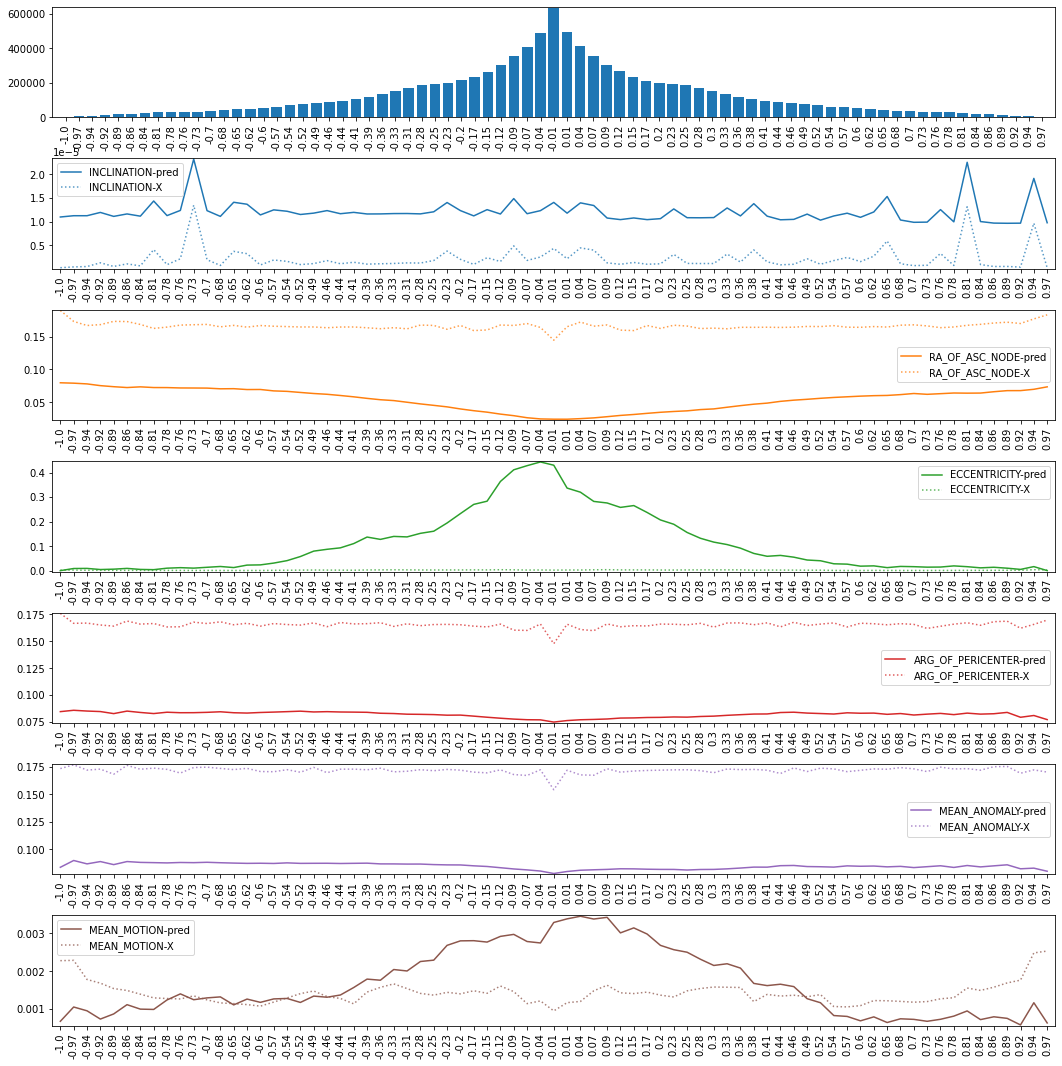

In [19]:
def plot_mse_by_epoch_diff_vs_x():
    bins=75
    n = len(y_cols)
    colors1=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink']
    colors2=['blue','orange','green','red','purple','brown','pink']
    fig, axs = plt.subplots(n+1,1,figsize=(15,n*2.5))
    fig.tight_layout(pad=2.0)
    
    y_pred_X = y_pred.copy()
    y_pred_X[y_cols] = X[y_cols]

    epoch_delta_count, bins = pd.cut(X.epoch_day_diff, bins=bins, labels=range(bins), retbins=True)
    epoch_delta_count = epoch_delta_count.reset_index()
    epoch_delta_count['X_labels']=epoch_delta_count['epoch_day_diff'].map({i:b for i,b in enumerate(bins)})
    xticks=[round(v, 2)for v in sorted(epoch_delta_count['X_labels'].unique())]
    by_count = epoch_delta_count.groupby('epoch_day_diff').count()['index']
    axs[0].bar(by_count.index, by_count)

    y_pred_se = (y-y_pred)**2
    y_pred_se['epoch_day_diff'] = epoch_delta_count['epoch_day_diff']
    y_pred_se.set_index('epoch_day_diff', inplace=True)
    y_pred_mse = (y_pred_se.groupby(level=0).sum() / y_pred_se.groupby(level=0).count())
    for i,col in enumerate(y_cols):
        axs[i+1].plot(y_pred_mse.index,y_pred_mse[col],color=colors1[i],label=f'{col}-pred')
    
    y_pred_se = (y-y_pred_X)**2
    y_pred_se['epoch_day_diff'] = epoch_delta_count['epoch_day_diff']
    y_pred_se.set_index('epoch_day_diff', inplace=True)
    y_pred_mse = (y_pred_se.groupby(level=0).sum() / y_pred_se.groupby(level=0).count())
    for i,col in enumerate(y_cols):
        axs[i+1].plot(y_pred_mse.index,y_pred_mse[col],':',color=colors1[i], alpha=0.75,label=f'{col}-X')
        axs[i+1].legend()
        
    for i in range(n+1):
        axs[i].margins(0.008)
        axs[i].set_xticks(sorted(epoch_delta_count['epoch_day_diff'].unique()))
        axs[i].set_xticklabels(xticks, rotation=90)
    
    return fig

fig = plot_mse_by_epoch_diff_vs_x()
plt.show()

# Get X,Y,Z Data

In [7]:
from sgp4.api import Satrec, SatrecArray, WGS72
from datetime import datetime
tqdm.pandas()

def get_satrec_erv(bst, ecc, aop, inc, mea, mem, raa, mmdot=0, mmddot=0, norad=0, tle_epoch=None, trg_epoch=None):
    '''
    Get cartesian coordinates of a satellite based on TLE parameters

     Parameters
     ----------
     bst : float : B-star
     ecc : float : eccentricity (in degrees)
     aop : float : argument of perigee (in degrees)
     inc : float : inclination (in degrees)
     mea : float : mean anomaly (in degrees)
     mem : float : mean motion (in degrees per minute)
     raa : float : right ascension of ascending node (in degrees)
     mmdot : float : NOT USED - ballistic coefficient
     mmddot : float : NOT USED - mean motion 2nd derivative
     norad : int : NOT USED - NORAD ID
     tle_epoch : Timestamp : TLE's epoch
     trg_epoch : Timestamp : moment in time to get position

     Returns
     -------
     list
         [e, rx, ry, rz, vx, vy, yz] error, position xyz, velocity xyz.  error = 0 is good
    '''
    try:
        r = datetime.strptime('12/31/1949 00:00:00', '%m/%d/%Y %H:%M:%S')
        epoch_days = (tle_epoch-r)/np.timedelta64(1, 'D')
        s = Satrec()
        s.sgp4init(
             WGS72,           # gravity model
             'i',             # 'a' = old AFSPC mode, 'i' = improved mode
             norad,               # satnum: Satellite number
             epoch_days,       # epoch: days since 1949 December 31 00:00 UT
             bst,      # bstar: drag coefficient (/earth radii)
             mmdot,   # ndot (NOT USED): ballistic coefficient (revs/day)
             mmddot,             # nddot (NOT USED): mean motion 2nd derivative (revs/day^3)
             ecc,       # ecco: eccentricity
             aop*np.pi/180, # argpo: argument of perigee (radians)
             inc*np.pi/180, # inclo: inclination (radians)
             mea*np.pi/180, # mo: mean anomaly (radians)
             mem*np.pi/(4*180), # no_kozai: mean motion (radians/minute)
             raa*np.pi/180, # nodeo: right ascension of ascending node (radians)
        )
        jday = __jday_convert(trg_epoch)
        e,r,v = s.sgp4(*jday)
        return pd.Series([e, *r, *v])
    except Exception as e:
        raise Exception(e)
        # e is SGP4 propagation errors, i've also added error 999 for when something goes wrong
        #return pd.Series([999, 0,0,0,0,0,0])

try:
    #raise Exception('force rebuild')
    xyz_pred = pd.read_pickle(f'data/secret_test_xyz_pred.pkl')
except:
    y_pred_dn = y_pred_dn.merge(X[['EPOCH','EPOCH_y','BSTAR']], left_index=True, right_index=True)
    predictions_sgp4 = y_pred_dn.progress_apply(lambda x:get_satrec_erv(bst=x.BSTAR,
                                                                          ecc=x.ECCENTRICITY,
                                                                          aop=x.ARG_OF_PERICENTER,
                                                                          inc=x.INCLINATION,
                                                                          mea=x.MEAN_ANOMALY,
                                                                          mem=x.MEAN_MOTION,
                                                                          raa=x.RA_OF_ASC_NODE,
                                                                          tle_epoch=x.EPOCH_y,
                                                                          trg_epoch=x.EPOCH_y,), axis=1)
    predictions_sgp4.columns = ["SAT_E","SAT_RX","SAT_RY","SAT_RZ","SAT_VX","SAT_VY","SAT_VZ"]
    y_pred_dn = y_pred_dn.merge(predictions_sgp4, left_index=True, right_index=True)
    #y_pred_dn.to_pickle(f'data/secret_test_y_pred_dn.pkl')

    predictions_sgp4 = X_dn.progress_apply(lambda x:get_satrec_erv(bst=x.BSTAR,
                                                                          ecc=x.ECCENTRICITY,
                                                                          aop=x.ARG_OF_PERICENTER,
                                                                          inc=x.INCLINATION,
                                                                          mea=x.MEAN_ANOMALY,
                                                                          mem=x.MEAN_MOTION,
                                                                          raa=x.RA_OF_ASC_NODE,
                                                                          tle_epoch=x.EPOCH,
                                                                          trg_epoch=x.EPOCH_y,), axis=1)
    predictions_sgp4.columns = ["SAT_E","SAT_RX","SAT_RY","SAT_RZ","SAT_VX","SAT_VY","SAT_VZ"]
    X_dn = X_dn.merge(predictions_sgp4, left_index=True, right_index=True)
    #X_dn.to_pickle(f'data/secret_test_X_dn.pkl')
    
    y_dn = y_dn.merge(X[['EPOCH_y','BSTAR']], left_index=True, right_index=True)
    predictions_sgp4 = y_dn.progress_apply(lambda x:get_satrec_erv(bst=x.BSTAR,
                                                                          ecc=x.ECCENTRICITY,
                                                                          aop=x.ARG_OF_PERICENTER,
                                                                          inc=x.INCLINATION,
                                                                          mea=x.MEAN_ANOMALY,
                                                                          mem=x.MEAN_MOTION,
                                                                          raa=x.RA_OF_ASC_NODE,
                                                                          tle_epoch=x.EPOCH_y,
                                                                          trg_epoch=x.EPOCH_y,), axis=1)
    predictions_sgp4.columns = ["SAT_E","SAT_RX","SAT_RY","SAT_RZ","SAT_VX","SAT_VY","SAT_VZ"]
    y_dn = y_dn.merge(predictions_sgp4, left_index=True, right_index=True)
    #y_dn.to_pickle(f'data/secret_test_y_dn.pkl')
    
    xyz_pred = X_dn[predictions_sgp4.columns].merge(y_pred_dn[predictions_sgp4.columns], left_index=True, right_index=True)
    xyz_pred = y_dn[predictions_sgp4.columns].merge(xyz_pred, left_index=True, right_index=True)
    
    xyz_pred = X[['epoch_day_diff']].merge(xyz_pred, left_index=True, right_index=True)
    xyz_pred = X[['EPOCH', 'EPOCH_y']].merge(xyz_pred, left_index=True, right_index=True)
    xyz_pred.to_pickle(f'data/secret_test_xyz_pred.pkl')

  0%|          | 0/9532782 [00:00<?, ?it/s]

  0%|          | 0/9532782 [00:00<?, ?it/s]

  0%|          | 0/9532782 [00:00<?, ?it/s]

In [8]:
def denormalize_epoch(df):
    odf = df.copy()
    min_date = '1990-01-01'
    max_date = '2021-04-05'
    sec = 86400
    mss = 1000000
    day_range = (datetime.strptime(max_date, '%Y-%m-%d') - datetime.strptime(min_date, '%Y-%m-%d')).days
    odf['epoch_diff'] = 0
    try:
        odf['epoch_day_diff'] = clean_data.normalize(odf.epoch_day_diff, min=-day_range, max=day_range, range=[-1,1], reverse=True)
        odf['epoch_diff'] = odf['epoch_day_diff']
    except:
        pass
    try:
        odf['epoch_sec_diff'] = clean_data.normalize(df['epoch_sec_diff'], min=0, max=sec, reverse=True)
        odf['epoch_diff'] = odf['epoch_diff'] + odf['epoch_sec_diff']/sec
    except:
        pass
    try:
        odf['epoch_ms_diff'] = clean_data.normalize(df['epoch_ms_diff'], min=0, max=mss, reverse=True)
        odf['epoch_diff'] = odf['epoch_diff'] + odf['epoch_sec_diff']/mss
    except:
        pass
    return odf

xyz_pred['epoch_sec_diff'] = X['epoch_sec_diff']
xyz_pred =  denormalize_epoch(xyz_pred[['epoch_day_diff','epoch_sec_diff']]).merge(xyz_pred, left_index=True, right_index=True)

In [9]:
def get_distance_diff(df1, df2, trg_cols):
    # ((x2 - x1)2 + (y2 - y1)2 + (z2 - z1)2)1/2
    xsq = df1.copy()
    ysq = df2.copy()
    xsq.columns = trg_cols
    ysq.columns = trg_cols
    return pd.DataFrame(np.sum((xsq-ysq)**2, axis=1)**0.5, columns=['dist_diff'])

pos_cols = ['SAT_RX','SAT_RY','SAT_RZ']
vel_cols = ['SAT_VX','SAT_VY','SAT_VZ']

y_diff = get_distance_diff(xyz_pred[[c+'_y' for c in pos_cols]], xyz_pred[pos_cols], pos_cols)
x_diff = get_distance_diff(xyz_pred[[c+'_x' for c in pos_cols]], xyz_pred[pos_cols], pos_cols)
x_diff['epoch_diff'] = xyz_pred['epoch_diff']
x_diff['epoch_day_diff'] = x_diff['epoch_diff'].astype(int)
y_diff['epoch_diff'] = xyz_pred['epoch_diff']
y_diff['epoch_day_diff'] = y_diff['epoch_diff'].astype(int)

bins=100
labels=[int(v) for v in np.linspace(x_diff.epoch_diff.min(),x_diff.epoch_diff.max(),bins+1)]
binned=pd.cut(x_diff.epoch_diff, bins=bins,labels=labels[1:])
x_diff['bin']=binned
y_diff['bin']=binned

(0.0, 14.0)

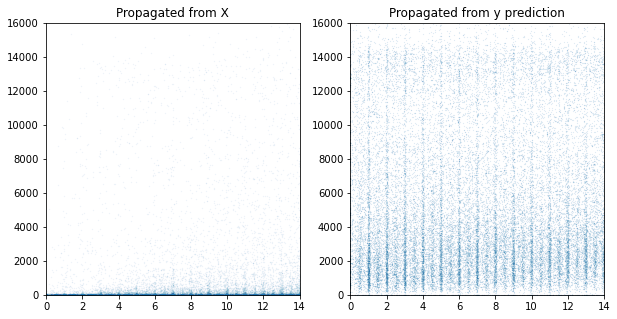

In [10]:
#x_diff.plot.scatter(x='epoch_day_diff',y='dist_diff',s=0.0001,alpha=0.1,title='Propigated from X')

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
x_diff_sample = x_diff.sample(100000)

ax1.scatter(x=x_diff['epoch_diff'],y=x_diff['dist_diff'],s=0.1, alpha=0.1)
ax1.set_title('Propagated from X')
ax1.set_ylim(0,16000)
ax1.set_xlim(0,14)

#y_diff.plot.scatter(x='epoch_day_diff',y='dist_diff',s=0.0001,alpha=0.1,title='Propigated from y prediction')
ax2.scatter(x=y_diff['epoch_diff'],y=y_diff['dist_diff'],s=0.01, alpha=0.5)
ax2.set_title('Propagated from y prediction')
ax2.set_ylim(0,16000)
ax2.set_xlim(0,14)


In [11]:
X

,BSTAR,INCLINATION,RA_OF_ASC_NODE,ECCENTRICITY,ARG_OF_PERICENTER,MEAN_ANOMALY,MEAN_MOTION,SUNSPOTS_1D,SUNSPOTS_3D,SUNSPOTS_7D,AIR_MONTH_AVG_TEMP,WATER_MONTH_AVG_TEMP,year,month_sin,month_cos,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,ms_sin,ms_cos,year_y,month_sin_y,month_cos_y,hour_sin_y,hour_cos_y,minute_sin_y,minute_cos_y,second_sin_y,second_cos_y,ms_sin_y,ms_cos_y,EPOCH,EPOCH_y,NORAD_CAT_ID,epoch_day_diff,epoch_sec_diff,epoch_ms_diff
0,0.0001,0.553438333333,0.085251944444,0.0247400,0.186124166667,0.815996944444,0.239106264000,0.040,0.022000000000,0.012857142857,0.573,0.458,0.580645161290,0.866025403784,-0.500000000000,-0.965925826289,0.258819045103,-0.587785252292,0.809016994375,-0.978147600734,-0.207911690818,0.668562310705,-0.743656127995,0.096774193548,0.000000000000,1.000000000000,0.258819045103,-0.965925826289,-0.207911690818,-0.978147600734,-0.866025403784,-0.500000000000,-0.999946390683,-0.010354504350,2008-05-16 19:54:43.383455,1993-01-17 11:32:40.748352,21338,0.490321450469,0.348634259259,0.635103
1,0.0000,0.552689444444,0.550222777778,0.0244596,0.865216388889,0.133639722222,0.238279594286,0.170,0.164000000000,0.207714285714,0.408,0.429,0.096774193548,0.000000000000,1.000000000000,0.258819045103,-0.965925826289,-0.207911690818,-0.978147600734,-0.866025403784,-0.500000000000,-0.999946390683,-0.010354504350,0.225806451613,0.000000000000,1.000000000000,-0.965925826289,0.258819045103,-0.500000000000,-0.866025403784,0.587785252292,0.809016994375,0.872551263253,0.488522561399,1993-01-17 11:32:40.748352,1997-01-05 19:35:06.168768,21338,-0.127003591136,0.664976851852,0.579584
2,0.0001,0.553558333333,0.308730833333,0.0246876,0.112939166667,0.888645555556,0.238408816000,0.026,0.018000000000,0.007714285714,0.364,0.373,0.225806451613,0.000000000000,1.000000000000,-0.965925826289,0.258819045103,-0.500000000000,-0.866025403784,0.587785252292,0.809016994375,0.872551263253,0.488522561399,0.387096774194,0.866025403784,0.500000000000,-0.500000000000,0.866025403784,0.743144825477,0.669130606359,0.500000000000,0.866025403784,-0.247320336921,-0.968933770154,1997-01-05 19:35:06.168768,2002-03-09 22:08:05.539775,21338,-0.165542611895,0.893750000000,0.628993
3,0.0001,0.552695555556,0.209585277778,0.0247556,0.397970000000,0.603533611111,0.238825449143,0.222,0.245333333333,0.294285714286,0.940,0.816,0.387096774194,0.866025403784,0.500000000000,-0.500000000000,0.866025403784,0.743144825477,0.669130606359,0.500000000000,0.866025403784,-0.247320336921,-0.968933770154,0.258064516129,-0.500000000000,0.866025403784,0.965925826289,0.258819045103,-0.866025403784,-0.500000000000,0.866025403784,-0.500000000000,0.963951397684,0.266078377370,2002-03-09 22:08:05.539775,1998-12-09 05:40:20.207136,21338,0.103880178681,0.685937500000,0.332639
4,0.0001,0.553406111111,0.142680555556,0.0244288,0.395079166667,0.606430277778,0.238476949714,0.318,0.313333333333,0.277428571429,0.654,0.568,0.258064516129,-0.500000000000,0.866025403784,0.965925826289,0.258819045103,-0.866025403784,-0.500000000000,0.866025403784,-0.500000000000,0.963951397684,0.266078377370,0.870967741935,-0.500000000000,-0.866025403784,-0.866025403784,0.500000000000,-0.866025403784,-0.500000000000,-0.994521895368,0.104528463268,-0.985788505684,0.167991136856,1998-12-09 05:40:20.207136,2017-08-05 20:40:46.776864,21338,-0.596916878339,0.374687500000,0.430272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9532777,0.0000,0.352270000000,0.410538611111,0.0012172,0.745323333333,0.254900555556,0.250530886857,0.000,0.017333333333,0.035428571429,0.883,0.733,1.000000000000,0.000000000000,1.000000000000,0.258819045103,-0.965925826289,0.743144825477,-0.669130606359,0.500000000000,0.866025403784,-0.526542770732,-0.850148640291,1.000000000000,0.000000000000,1.000000000000,0.707106781187,0.707106781187,0.406736643076,-0.913545457643,0.951056516295,0.309016994375,0.879914074330,-0

In [12]:
((x_diff.dist_diff - y_diff.dist_diff)>0).value_counts()

True     6146365
False    3386417
Name: dist_diff, dtype: int64

(0.0, 2000.0)

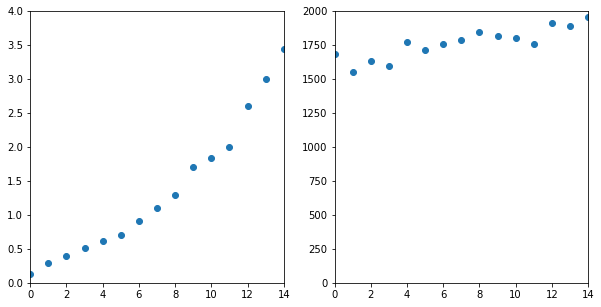

In [13]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

t = x_diff.groupby('epoch_day_diff').apply(lambda x:np.mean(x.dist_diff.nsmallest(len(x)//2)))
ax1.scatter(t.index, t)

t = y_diff.groupby('epoch_day_diff').apply(lambda x:np.mean(x.dist_diff.nsmallest(len(x)//2)))
ax2.scatter(t.index, t)
ax1.set_xlim(0,14)
ax1.set_ylim(0,4)
ax2.set_xlim(0,14)
ax2.set_ylim(0,2000)

epoch_day_diff
0     0.025121859768
1     0.036703601108
2     0.039790575916
3     0.047981721249
4     0.046828908555
5     0.049378062571
6     0.055741360089
7     0.056504065041
8     0.065899166336
9     0.069144684253
10    0.073790322581
11    0.088072669826
12    0.085904920767
13    0.088175538399
14    0.093032786885
15    0.100947672023
dtype: float64

<AxesSubplot:title={'center':'Percent time model outperforms SGP4'}, xlabel='epoch_day_diff'>

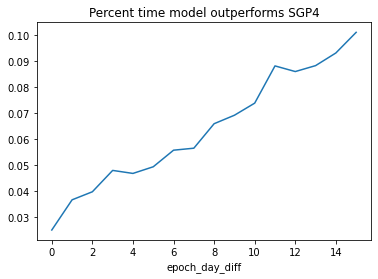

In [14]:
#((x_diff.dist_diff - y_diff.dist_diff)>0)
tmp = x_diff.copy()
tmp['model_better'] = (x_diff.dist_diff > y_diff.dist_diff)
better_against_epoch_diff = tmp.groupby('epoch_day_diff').apply(lambda x:np.mean(x.model_better))
#better_against_epoch_diff.loc[0:15]
display(better_against_epoch_diff.loc[0:15])
better_against_epoch_diff.loc[0:15].plot(title='Percent time model outperforms SGP4')